In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
import cv2

%matplotlib inline

In [2]:
# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for i, filename in enumerate(images):
    img = cv2.imread(filename)
    img_chessboard = np.copy(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw chessboard
        cv2.drawChessboardCorners(img_chessboard, (9,6), corners, ret)


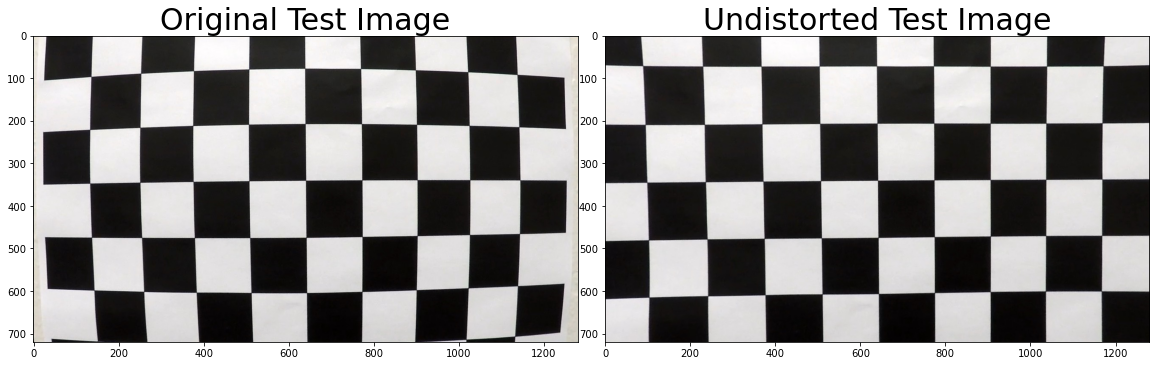

In [3]:
mpimg.imread("camera_cal/calibration1.jpg")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

# Read a test image
img = mpimg.imread("camera_cal/calibration1.jpg")
# Undistorting the test image
img2 = cv2.undistort(img, mtx, dist, None, mtx)

# Plot Original and Undistorted Test Image
plt.figure(figsize=(20,50))
plt.subplots_adjust(hspace = .2, wspace=.05)

# Plot Original Test Image
plt.subplot(1,2,1)
plt.title('Original Test Image', fontsize=30)
fig =plt.imshow(img)

# Plot Undistorted Test Image
plt.subplot(1,2,2)
plt.title('Undistorted Test Image', fontsize=30)
fig =plt.imshow(img2)

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    
    # using CV2 Undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist

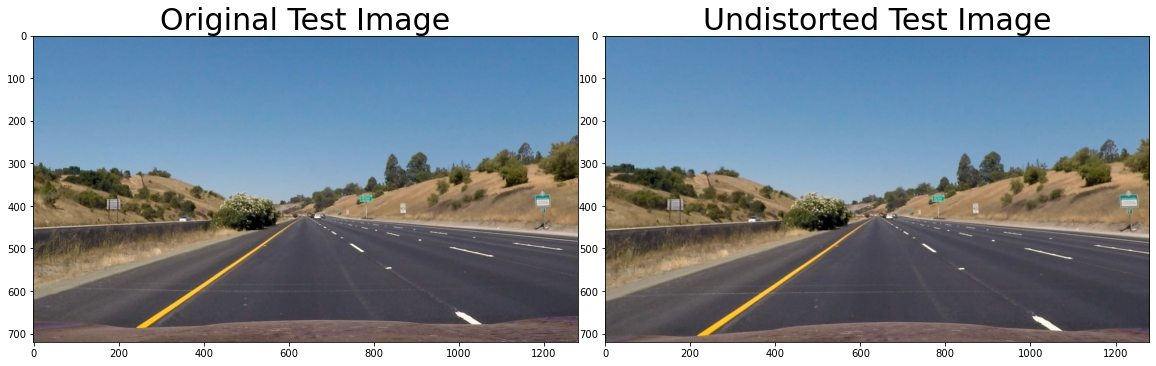

In [5]:
# Read a test image
img = mpimg.imread("test_images/straight_lines1.jpg")
# Undistorting the test image


img_undistorted = cal_undistort(img, objpoints, imgpoints)

# Plot Original and Undistorted Test Image
plt.figure(figsize=(20,50))
plt.subplots_adjust(hspace = .2, wspace=.05)

# Plot Original Test Image
plt.subplot(1,2,1)
plt.title('Original Test Image', fontsize=30)
fig =plt.imshow(img)

# Plot Undistorted Test Image
plt.subplot(1,2,2)
plt.title('Undistorted Test Image', fontsize=30)
fig =plt.imshow(img_undistorted)

(1280, 720)


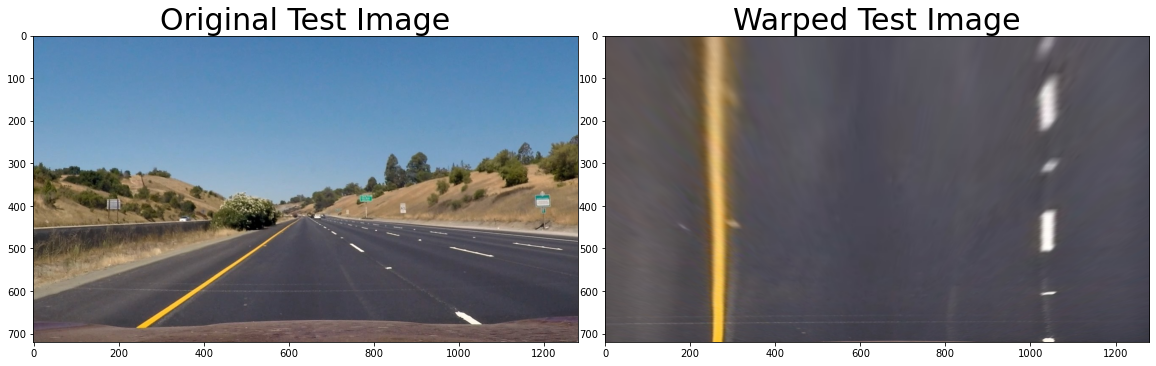

In [6]:
# capture image dimensions
img_size = (img.shape[1], img.shape[0])

#width and height
w = img.shape[1]
h = img.shape[0]

print(img_size)
# Set parameter to source and destination point of views
top_right = (725, 455)
top_left = (555, 455)
botom_right = (1280, 680)
botom_left = (0, 680)

# Source
src = np.float32([[top_right],[top_left],[botom_right],[botom_left]])

# Destination
dst = np.float32([[w,0],[0,0],[w,h],[0,h]])

# Creating a Matriz form source and destination points and transform image
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img_undistorted, M, img_size, flags=cv2.INTER_LINEAR)

# Plot Original and Undistorted Test Image
plt.figure(figsize=(20,50))
plt.subplots_adjust(hspace = .2, wspace=.05)

# Plot Original Test Image
plt.subplot(1,2,1)
plt.title('Original Test Image', fontsize=30)
fig =plt.imshow(img)

# Plot Undistorted Test Image
plt.subplot(1,2,2)
plt.title('Warped Test Image', fontsize=30)
fig =plt.imshow(warped)

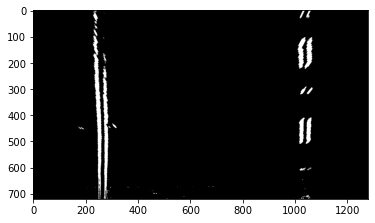

In [7]:
#transform in gray scale
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

#aplying CV2 Sobel
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
#Take the absolute value of the output from cv2.Sobel()
abs_sobelx = np.absolute(sobelx)
# Scale the result to an 8-bit range (0-255)
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Apply lower and upper thresholds
thresh_min = 20
thresh_max = 100

# Create binary_output
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray')

In [8]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

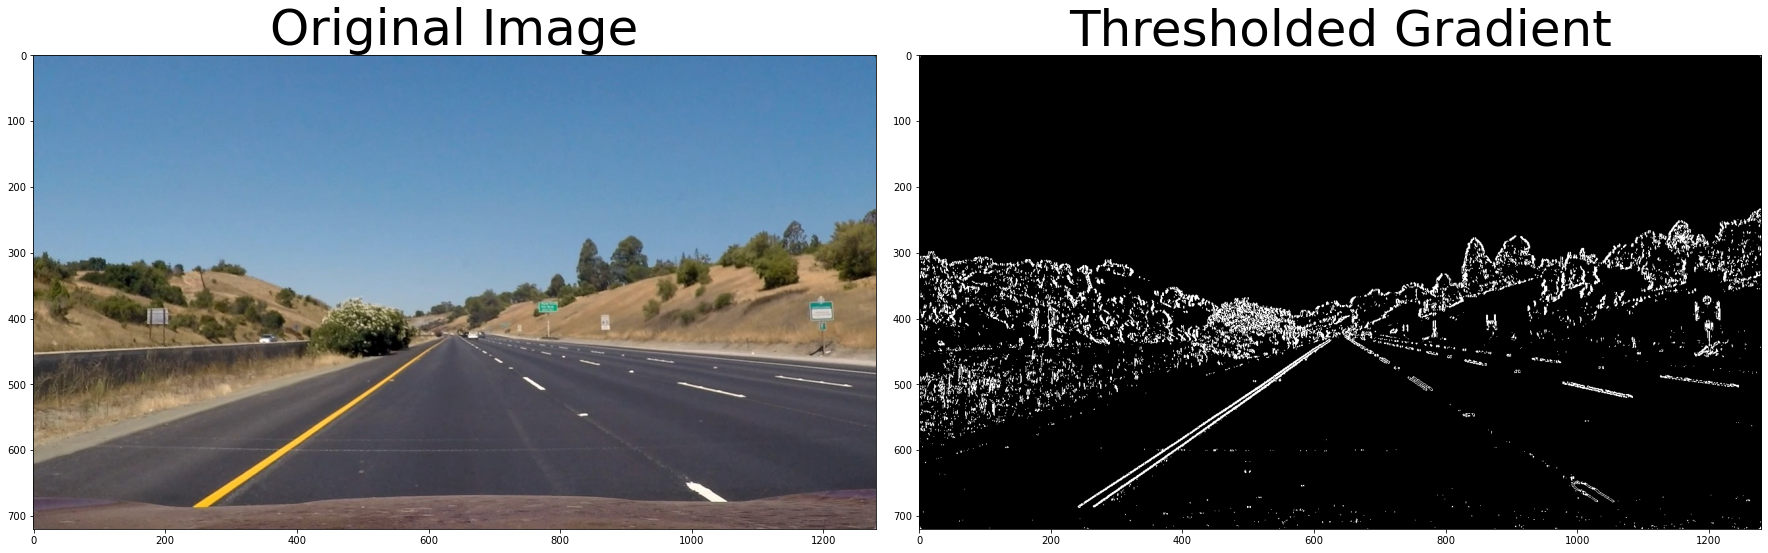

In [9]:
# Run the function
grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

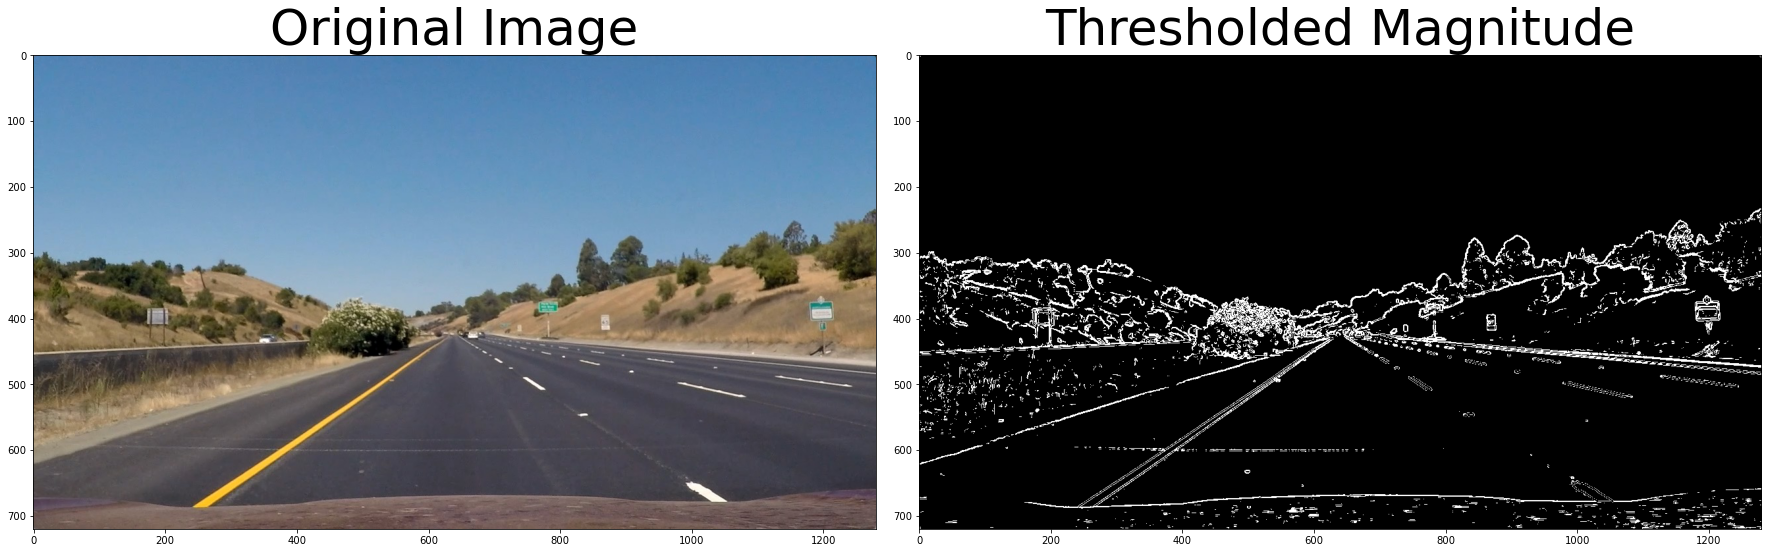

In [11]:
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

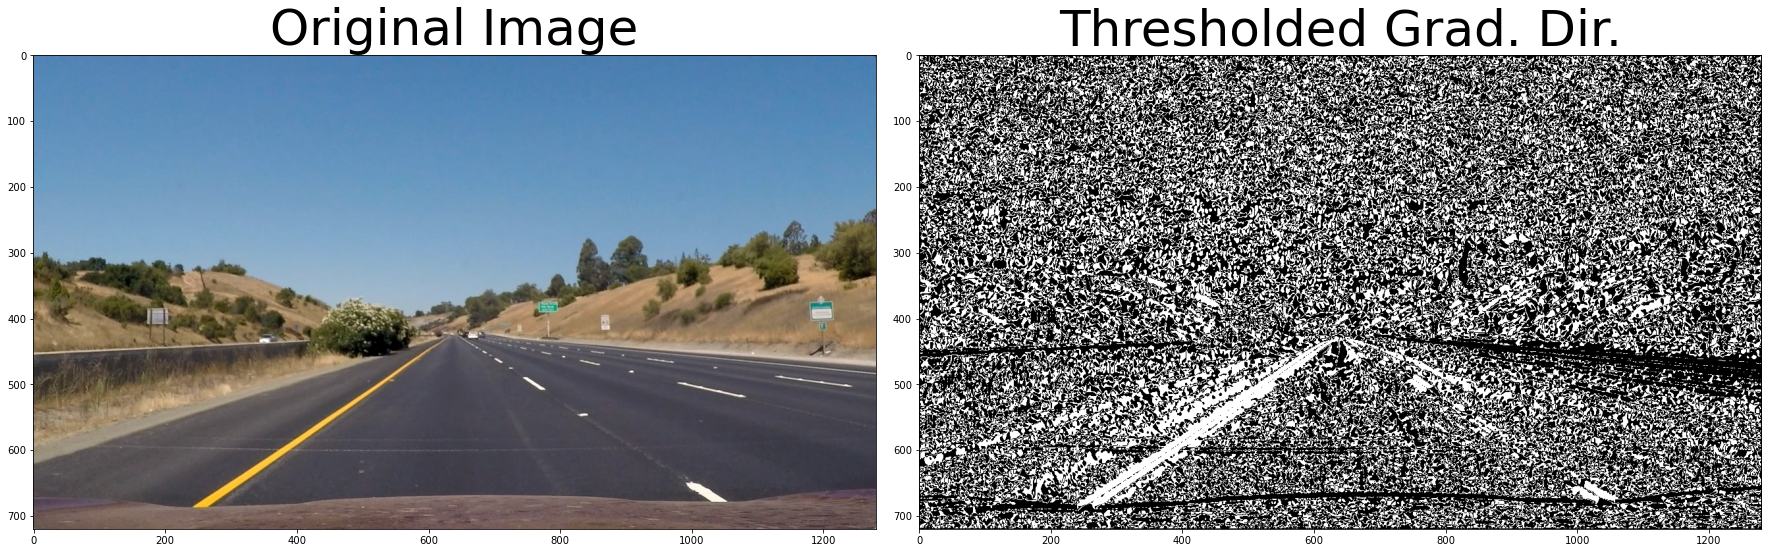

In [13]:
# Run the function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

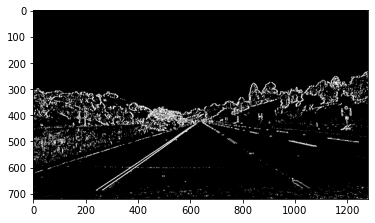

In [15]:
#combining results
combined = np.zeros_like(dir_binary)
combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

In [ ]:
def hls_select(img, thresh=(0, 255)):
    #converting from RBG to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #S channel
    s_channel = hls[:,:,2]
    #creating a binary output using S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
